In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Scikit-learn version 0.24.2
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# I am suppressing warnings for chain assignments
pd.options.mode.chained_assignment = None

In [2]:
# Import csv and check headers

stardataraw = pd.read_csv("hipparcos.csv")
stardataraw.columns.values

array(['Catalog', 'HIP', 'Proxy', 'RAhms', 'DEdms', 'Vmag', 'VarFlag',
       'r_Vmag', 'RAdeg', 'DEdeg', 'AstroRef', 'Plx', 'pmRA', 'pmDE',
       'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA',
       'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA',
       'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', '---', 'BTmag',
       'e_BTmag', 'VTmag', 'e_VTmag', 'm_BTmag', 'B-V', 'e_B-V', 'r_B-V',
       'V-I', 'e_V-I', 'r_V-I', 'CombMag', 'Hpmag', 'e_Hpmag', 'Hpscat',
       'o_Hpmag', 'm_Hpmag', 'Hpmax', 'HPmin', 'Period', 'HvarType',
       'moreVar', 'morePhoto', 'CCDM', 'n_CCDM', 'Nsys', 'Ncomp',
       'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho',
       'dHp', 'e_dHp', 'Survey', 'Chart', 'Notes', 'HD', 'BD', 'CoD',
       'CPD', '(V-I)red', 'SpType', 'r_SpType'], dtype=object)

In [3]:
# Check number of classes in SpType

stardataraw["SpType"].nunique()

4124

In [4]:
stardata = stardataraw.copy()

# Drop ambiguous classification
stardata = stardata[stardata["SpType"].str.contains("/|-")==False]

# Extract and apply new labels
stardata.loc[stardata["SpType"].str.contains("VII") == True, "SpType"] = "White_Dwarf"
#Some values of sub drawf are sd instead of more standard VI
stardata.loc[stardata["SpType"].str.contains("VI|sd") == True, "SpType"] = "Sub_Dwarf"
stardata.loc[stardata["SpType"].str.contains("IV") == True, "SpType"] = "Sub_Giant"
#Note that IV needs to be before V to keep it from replacing wrong values
stardata.loc[stardata["SpType"].str.contains("V") == True, "SpType"] = "Main_Sequence"
stardata.loc[stardata["SpType"].str.contains("III") == True, "SpType"] = "Normal_Giant"
stardata.loc[stardata["SpType"].str.contains("II") == True, "SpType"] = "Bright_Giant"
stardata.loc[stardata["SpType"].str.contains("Ib|Ia|Iab") == True, "SpType"] = "Super_Giant"

#Filter types non-attributed with Yerkes class
stardata = stardata[stardata["SpType"]
                    .str.contains("White_Dwarf|Sub_Dwarf|Main_Sequence|Sub_Giant|Normal_Giant|Bright_Giant|Super_Giant")==True]

# Display number of entries
len(stardata)

44675

In [5]:
# Get count of classes

stardata["SpType"].value_counts()

Main_Sequence    21641
Normal_Giant     17346
Sub_Giant         3795
Bright_Giant       972
Super_Giant        849
Sub_Dwarf           69
White_Dwarf          3
Name: SpType, dtype: int64

### Change classes to Dwarf / Giant

In [6]:
stardata = stardataraw.copy()

# Drop ambiguous classification
stardata = stardata[stardata["SpType"].str.contains("/|-")==False]

# Extract and apply new labels
stardata.loc[stardata["SpType"].str.contains("VII") == True, "SpType"] = "Dwarf"
#Some values of sub drawf are sd instead of more standard VI
stardata.loc[stardata["SpType"].str.contains("VI|sd") == True, "SpType"] = "Dwarf"
stardata.loc[stardata["SpType"].str.contains("IV") == True, "SpType"] = "Giant"
#Note that IV needs to be before V to keep it from replacing wrong values
stardata.loc[stardata["SpType"].str.contains("V") == True, "SpType"] = "Dwarf"
stardata.loc[stardata["SpType"].str.contains("III") == True, "SpType"] = "Giant"
stardata.loc[stardata["SpType"].str.contains("II") == True, "SpType"] = "Giant"
stardata.loc[stardata["SpType"].str.contains("Ib|Ia|Iab") == True, "SpType"] = "Giant"

#Filter types non-attributed with Yerkes class
stardata = stardata[stardata["SpType"]
                    .str.contains("Dwarf|Giant")==True]

len(stardata)

44675

In [7]:
# Get count of classes

stardata["SpType"].value_counts()

Giant    22962
Dwarf    21713
Name: SpType, dtype: int64

### Classifying with absolute magnitude

In [8]:
# Function for calculating absolute magnitude

def abs_mag(Plx, Vmag):
    # Plx = Parallax
    # Vmag = apparent magnitude
    # Mv = absolute magnitude
    
    parsecs = 1/Plx*1000
    Mv = 0
    Mv = Vmag - 5*np.log10(parsecs/10)
    
    return Mv  

In [9]:
# Clean up the data a bit more

stardata_with_Mv = stardata.loc[:,['Vmag', 'Plx', 'B-V', 'V-I', 'SpType']]
stardata_with_Mv = stardata_with_Mv.dropna()
stardata_with_Mv["Plx"] = stardata_with_Mv["Plx"].apply(abs)
stardata_with_Mv = stardata_with_Mv[stardata_with_Mv["Plx"] > 0]

stardata_with_Mv["Mv"] = stardata_with_Mv.apply(lambda x: abs_mag(x['Plx'], x["Vmag"]), axis = 1)

stardata_with_Mv = stardata_with_Mv.drop(["Plx","Vmag",], axis = 1)

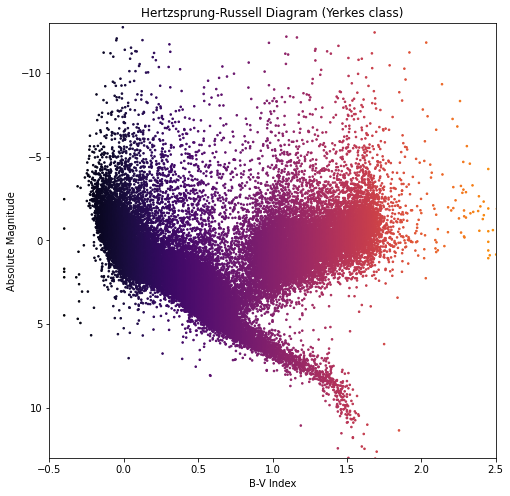

In [10]:
# Make an HR diagram from data

BVindex = np.array(stardata_with_Mv["B-V"], dtype=float).tolist()
Mv = np.array(stardata_with_Mv["Mv"], dtype=float).tolist()

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(BVindex, Mv, cmap = "inferno", c = BVindex, marker = '.', s = 10)

plt.title("Hertzsprung-Russell Diagram (Yerkes class)")
plt.xlabel("B-V Index")
plt.ylabel("Absolute Magnitude")

plt.xlim(-0.5, 2.5)
plt.ylim(13, -13) 

plt.show()

In [11]:
X, y = stardata_with_Mv.drop(columns=["SpType"]), stardata_with_Mv["SpType"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_svm_with_Mv = SVC(kernel="linear", C=1, decision_function_shape="ovo")
model_svm_with_Mv.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [12]:
# Print accuracy across 3 folds and predicted accuracy

X, y = stardata_with_Mv.drop(columns=["SpType"]), stardata_with_Mv["SpType"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_svm_with_Mv = SVC(kernel="linear", C=1, decision_function_shape="ovo")
model_svm_with_Mv.fit(X_train, y_train)

print(cross_val_score(model_svm_with_Mv, X_train, y_train, cv=3, scoring ="accuracy"))
y_train_pred_acc = model_svm_with_Mv.predict(X_test)
print(accuracy_score(y_test, y_train_pred_acc))

[0.86078828 0.85336478 0.85656532]
0.8557152481473164


In [13]:
# Print classification report of precision, recall, and f1

target_names = ["Dwarf", "Giant"]
y_train_pred = cross_val_predict(model_svm_with_Mv, X_train, y_train, cv=3)
print(classification_report(y_train, y_train_pred, target_names=target_names))

              precision    recall  f1-score   support

       Dwarf       0.80      0.94      0.86     17302
       Giant       0.93      0.78      0.85     18318

    accuracy                           0.86     35620
   macro avg       0.87      0.86      0.86     35620
weighted avg       0.87      0.86      0.86     35620



<function matplotlib.pyplot.show(close=None, block=None)>

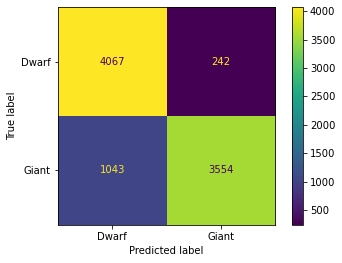

In [14]:
# Display confusion matrix

plot_confusion_matrix(model_svm_with_Mv, X_test, y_test)
plt.show

### Classifying without absolute magnitude

In [15]:
stardata_no_Mv = stardata.loc[:,['Vmag', 'BTmag','VTmag', 'Hpmag','Plx','e_Plx', 'B-V','e_B-V', 'V-I','e_V-I', 'SpType']]
stardata_no_Mv = stardata_no_Mv.dropna()

X, y = stardata_no_Mv.drop(columns=["SpType"]), stardata_no_Mv["SpType"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_svm_no_Mv = SVC(kernel="linear", C=1, decision_function_shape="ovo")
model_svm_no_Mv.fit(X_train, y_train)

print(cross_val_score(model_svm_no_Mv, X_train, y_train, cv=3, scoring ="accuracy"))
y_train_pred_acc = model_svm_no_Mv.predict(X_test)
print(accuracy_score(y_test, y_train_pred_acc))

[0.85574883 0.8525244  0.8607552 ]
0.8551872383753818


In [16]:
# Print classification report of precision, recall, and f1

target_names = ["Dwarf", "Giant"]
y_train_pred = cross_val_predict(model_svm_no_Mv, X_train, y_train, cv=3)
print(classification_report(y_train, y_train_pred, target_names=target_names))

              precision    recall  f1-score   support

       Dwarf       0.78      0.97      0.87     17004
       Giant       0.96      0.75      0.84     18351

    accuracy                           0.86     35355
   macro avg       0.87      0.86      0.86     35355
weighted avg       0.88      0.86      0.86     35355



<function matplotlib.pyplot.show(close=None, block=None)>

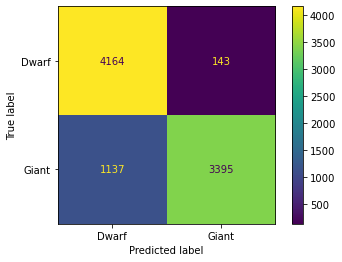

In [17]:
# Display confusion matrix

plot_confusion_matrix(model_svm_no_Mv, X_test, y_test)
plt.show

In [18]:
# Check correlation with Mv

stardata_with_Mv2 = stardata_with_Mv.copy()
stardata_with_Mv2.loc[stardata["SpType"].str.contains("Dwarf") == True, "SpType"] = 0.0
stardata_with_Mv2.loc[stardata["SpType"].str.contains("Giant") == True, "SpType"] = 1.0
stardata_with_Mv2 = stardata_with_Mv2.astype('float64')
stardata_with_Mv2.corr()

,B-V,V-I,SpType,Mv
B-V,1.000000,0.944691,0.532028,-0.068760
V-I,0.944691,1.000000,0.471771,-0.056966
SpType,0.532028,0.471771,1.000000,-0.475941
Mv,-0.068760,-0.056966,-0.475941,1.000000


In [19]:
# Check correlation without Mv

stardata_no_Mv2 = stardata_no_Mv.copy()
stardata_no_Mv2.loc[stardata["SpType"].str.contains("Dwarf") == True, "SpType"] = 0.0
stardata_no_Mv2.loc[stardata["SpType"].str.contains("Giant") == True, "SpType"] = 1.0
stardata_no_Mv2 = stardata_no_Mv2.astype('float64')
stardata_no_Mv2.corr()

,Vmag,BTmag,VTmag,Hpmag,Plx,e_Plx,B-V,e_B-V,V-I,e_V-I,SpType
Vmag,1.000000,0.896193,0.998301,0.998757,-0.189021,0.360642,0.042469,0.158982,0.036711,0.157247,-0.203632
BTmag,0.896193,1.000000,0.915529,0.906682,-0.183016,0.314941,0.477746,0.185698,0.450760,0.279044,0.064418
VTmag,0.998301,0.915529,1.000000,0.998242,-0.189145,0.359737,0.086888,0.167903,0.080341,0.173859,-0.178878
Hpmag,0.998757,0.906682,0.998242,1.000000,-0.183126,0.359715,0.069488,0.158446,0.053220,0.152302,-0.188575
Plx,-0.189021,-0.183016,-0.189145,-0.183126,1.000000,0.012727,-0.028105,-0.045395,-0.009798,-0.046885,-0.293542
e_Plx,0.360642,0.314941,0.359737,0.359715,0.012727,1.000000,-0.001747,0.175747,0.002561,0.137566,-0.145763
B-V,0.042469,0.477746,0.086888,0.069488,-0.028105,-0.001747,1.000000,0.079649,0.945850,0.297039,0.541563
e_B-V,0.158982,0.185698,0.167903,0.158446,-0.045395,0.175747,0.079649,1.000000,0.082180,0.356203,-0.000224
V-I,0.036711,0.450760,0.080341,0.053220,-0.009798,0.002561,0.945850,0.082180,1.000000,0.350151,0.484551
e_V-I,0.157247,0.279044,0.173859,0.152302,-0.046885,0.137566,0.297039,0.356203,0.350151,1.000000,0.103593
